# Install tensorflow, Import that smooth library

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import csv
from pandas import read_csv
from plotly.subplots import make_subplots

# Download the Data

In [2]:
# prepare the dataset, 
# download data from google drive
# https://drive.google.com/file/d/1kGgh31KDKdldPounyj1Z5vlnTE-HHctT/view?usp=sharing

!gdown --id 1kGgh31KDKdldPounyj1Z5vlnTE-HHctT

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1kGgh31KDKdldPounyj1Z5vlnTE-HHctT
To: /content/Beras Kualitas Bawah II (kg) 2019-2022.csv
100% 16.3k/16.3k [00:00<00:00, 15.8MB/s]


# Preprocess the data

In [3]:
# read the dataset and convert into csv
df = pd.read_csv('Beras Kualitas Bawah II (kg) 2019-2022.csv')
# show me that csv
print(df)

     Unnamed: 0        Date  Price
0             0  2019-03-01   8800
1             1  2019-03-04   8800
2             2  2019-03-05   8900
3             3  2019-03-06   8900
4             4  2019-03-08   8900
..          ...         ...    ...
778         778  2022-04-29   8300
779         779  2022-05-04   8300
780         780  2022-05-05   8350
781         781  2022-05-06   8300
782         782  2022-05-09   8550

[783 rows x 3 columns]


In [4]:
# download the data
y = df['Price'].fillna(method='ffill')
y = y.values.reshape(-1, 1)

In [5]:
# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

# Generate the Input and Output sequences

In [6]:
# generate the input and output sequences
n_lookback = 60  # length of input sequences (lookback period)
n_forecast = 30  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

# Setting up the plot function for plotting

In [7]:
def plot_series(x, y, format="-", start=0, end=None, 
                title='Price Forecasting ML Model with CNN_RNN_DNN', xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(16, 8))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

# Build the Model
You've seen these layers before and here is how it's looks like when combined.

In [8]:
# make the model
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(n_lookback, 1)),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(n_forecast)])

# Print the model summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
Total params: 51,870
Trainable params: 51,870
Non-trainable params: 0
_________________________________________________________________


# Now let’s compile and train the model
Now you can proceed to reset and train the model. It is set for 100 epochs in the cell below.

In [9]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
history = model.fit(X, Y, epochs=100, batch_size=32, verbose=0)

You can visualize the training and see if the loss and MAE are still trending down.

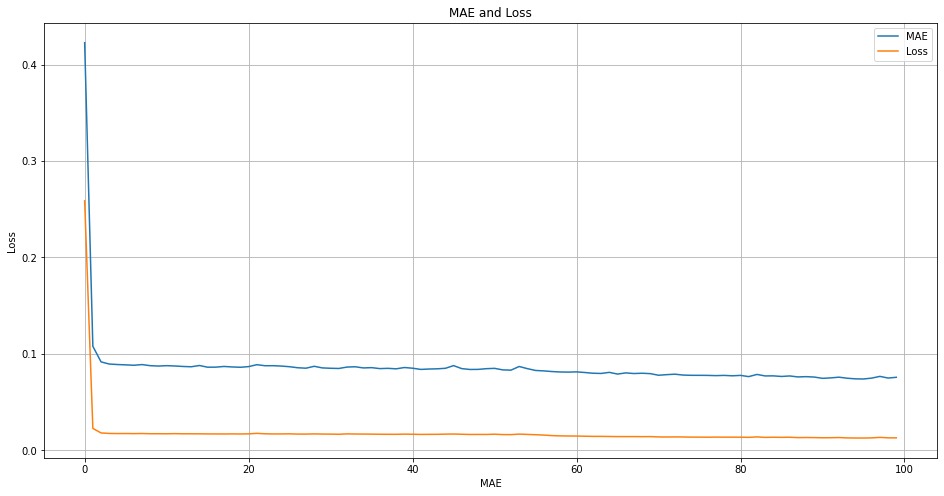

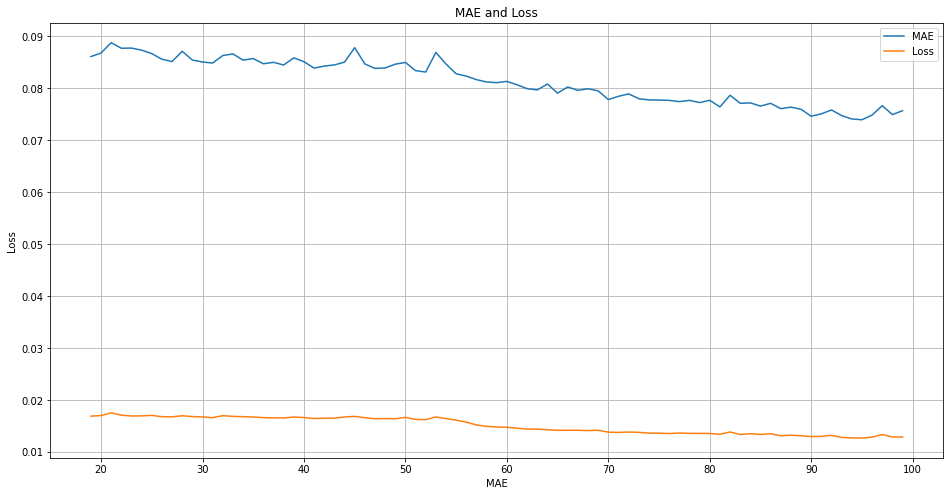

In [10]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Forecasting Out-Of-Sample data

You could train your model to predict a future sequence (e.g. the next 30 days) instead of predicting the next value (the next day) as it is currently the case.

In order to do that, you need to define the outputs as y[t: t + H] (instead of y[t] as in the current code) where y is the time series and H is the length of the forecast period (i.e. the number of days ahead that you want to forecast). You also need to set the number of outputs of the last layer equal to H (instead of equal to 1 as in the current code).

You can still define the inputs as y[t - T: t] where T is the length of the lookback period (or number of timesteps), and therefore the model's input shape is still (T, 1). The lookback period T is usually longer than the forecast period H (i.e. T > H) and it's often set equal to a multiple of H (i.e. T = m * H where m > 1 is an integer.).

In [11]:
# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

In [12]:
df['Date'] = pd.to_datetime(df['Date'], format = "%Y-%m-%d")
df_past = df[['Price']].reset_index()
df_past.rename(columns={'index': 'Date', 'Price': 'Actual'}, inplace=True)
df_past['Date'] = df['Date']
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

In [13]:
results = df_past.append(df_future)

In [14]:
print(results)

         Date  Actual     Forecast
0  2019-03-01  8800.0          NaN
1  2019-03-04  8800.0          NaN
2  2019-03-05  8900.0          NaN
3  2019-03-06  8900.0          NaN
4  2019-03-08  8900.0          NaN
..        ...     ...          ...
25 2022-06-04     NaN  8550.469727
26 2022-06-05     NaN  8550.683594
27 2022-06-06     NaN  8579.662109
28 2022-06-07     NaN  8489.892578
29 2022-06-08     NaN  8408.294922

[813 rows x 3 columns]


In [15]:
fig = px.line(results, x=results.Date, y=results.columns)

fig.update_xaxes(rangeslider_visible=True)

fig.show()

# Save model to h5 format

In [16]:
model.save('forecasting_model.h5')

from google.colab import files
files.download('forecasting_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Save Model to folder

In [17]:
from tensorflow import keras

# Calling `save('my_model')` creates a SavedModel folder `my_model`.
model.save("my_model")

# save to zip
!zip -r /content/my_model.zip /content/my_model
files.download("/content/my_model.zip")

# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("my_model")

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


  adding: content/my_model/ (stored 0%)
  adding: content/my_model/assets/ (stored 0%)
  adding: content/my_model/saved_model.pb (deflated 90%)
  adding: content/my_model/keras_metadata.pb (deflated 89%)
  adding: content/my_model/variables/ (stored 0%)
  adding: content/my_model/variables/variables.index (deflated 65%)
  adding: content/my_model/variables/variables.data-00000-of-00001 (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>